<img src="https://heig-vd.ch/docs/default-source/doc-global-newsletter/2020-slim.svg" alt="HEIG-VD Logo" width="100" align="right" /> 

# Cours TAL - Laboratoire 4<br/>Reconnaissance des entités nommées

**Objectif**

L'objectif de ce travail est de comparer la reconnaissance des entités nommées (*named entity recognition*, NER) faite par quatre systèmes : NLTK, spaCy (deux modèles, 'en_core_web_sm' et 'en_core_web_lg'), et DistilBERT/NER.  Les données de test en anglais vous sont fournies sur Cyberlearn au format CoNLL.  Pour comparer les systèmes, on utilise la macro-moyenne des scores f1 pour chaque étiquette.  Vous pouvez concevoir l'ensemble du projet par vous-mêmes, ou suivre les indications suivantes.

## 1. NER avec spaCy et NLTK sur un texte court

In [1]:
import re
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import spacy
from spacy.tokens import Doc

In [2]:
# !python -m spacy download en_core_web_sm
# exécuter la ligne ci-dessus une fois, si nécessaire, idem pour en_core_web_lg

In [3]:
nlp = spacy.load("en_core_web_sm")

In [4]:
raw_text = "Reinhold Messner made a solo ascent of Mount Everest and was later a member of the European Parliament."

**1a.** Veuillez traiter ce texte avec la pipeline 'nlp', et pour chaque entité nommée trouvée veuillez afficher les mots qui la composent et son type.

In [5]:
docs = nlp(raw_text)

for ent in docs.ents:
    print(f"{ent.text} [{ent.label_}] - {type(ent)}")

Reinhold Messner [ORG] - <class 'spacy.tokens.span.Span'>
Mount Everest [LOC] - <class 'spacy.tokens.span.Span'>
the European Parliament [ORG] - <class 'spacy.tokens.span.Span'>


In [6]:
import nltk
# nltk.download('maxent_ne_chunker')
# nltk.download('words')
# exécuter les deux lignes ci-dessus une fois, si nécessaire

**1b.** Veuillez effectuer avec NLTK la tokenization, le POS tagging et le *NE chunking* de `raw_text` (voir la [documentation NLTK](https://www.nltk.org/api/nltk.chunk.ne_chunk.html#nltk.chunk.ne_chunk)).  Veuillez afficher le résultat et indiquer son type.

In [7]:
tokens = nltk.word_tokenize(raw_text)
pos_tags = nltk.pos_tag(tokens)
ne_tree = nltk.ne_chunk(pos_tags)

print(ne_tree)
print("\n", type(ne_tree))

(S
  (PERSON Reinhold/NNP)
  (PERSON Messner/NNP)
  made/VBD
  a/DT
  solo/JJ
  ascent/NN
  of/IN
  (PERSON Mount/NNP Everest/NNP)
  and/CC
  was/VBD
  later/RB
  a/DT
  member/NN
  of/IN
  the/DT
  (ORGANIZATION European/NNP Parliament/NNP)
  ./.)

 <class 'nltk.tree.tree.Tree'>


**1c.** Veuillez afficher, pour chaque entité nommée, les mots qui la composent et son type.  Vous pouvez parcourir le résultat précédent avec une boucle `for`, et déterminer si un noeud possède une étiquette avec la fonction `hasattr(noeud, 'label')`.

In [8]:
for subtree in ne_tree:
    if hasattr(subtree, 'label'):
        print(subtree.label(), ' '.join([word for word, pos in subtree.leaves()]))

PERSON Reinhold
PERSON Messner
PERSON Mount Everest
ORGANIZATION European Parliament


**1d.** À ce stade, que pensez-vous de la qualité des résultats de chaque système ?

> Les entités nommées détectées par spaCy sont correctes, à l'exception de Reinhold Messner qui n'est pas une organisation, mais bien une personne. NLTK a un peu plus de peine, puisque seuls l'entité nommée "European Parliament" est correctement identifiée et possède les bonnes branches. En effet, bien que correctement identifié comme une personne, "Reinhold Messner" est séparé en deux entités nommées distinctes tandis que "Mount Everest" est considéré comme une personne.
>
> Globalement, les deux systèmes sont des résultats relativement similaires, bien que spaCy offre une meilleure précision sur les branches de l'arbre regroupant les entités nommées des noms composés.

## 2. Prise en main des données de test

**2a.** Quel est le format du fichier `eng.test.a.conll` ?  Quelle information contient chaque colonne ?  Quel est le format des tags NE ?

Note : ce fichier fait partie des données de test pour la NER sur l'anglais de la conférence [CoNLL](https://www.clips.uantwerpen.be/pages/past-workshops) 2003. On peut lire [ici](https://www.clips.uantwerpen.be/conll2003/ner/) la description de la tâche et les scores obtenus.  On peut trouver une copie des données [ici](https://sourceforge.net/p/text-analysis/svn/1243/tree/text-analysis/trunk/Corpora/CoNLL/2003/) ou [ici](https://github.com/synalp/NER/tree/master/corpus/CoNLL-2003).  Les textes proviennent du [corpus Reuters](http://trec.nist.gov/data/reuters/reuters.html).

> Le fichier `eng.test.a.conll` est un fichier texte contenant quatre colonnes, séparées par des espaces :    
> - Première colonne : le mot    
> - Seconde colonne : l'étiquette morphosyntaxique (POS tag)    
> - Troisième colonne : L'étiquette du bloc syntaxique (syntactic chunk tag)    
> - Quatrième colonne : L'étiquette d'entité nommée (NE tag)    
> 
> Les différentes phrases présentes dans le fichier sont séparées par une ligne vide.
>
> Les tags NE sont au format IOB :    
> - I-TYPE indique qu'un mot fait partie d'une entité nommée de type TYPE    
> - B-TYPE indique qu'un mot est le premier d'une nouvelle entité nommée, lorsqu'il y a deux groupes consécutifs du même type    
> - O indique qu'il n'y a pas d'entité nommée
>
> CoNLL-2003 se concentre sur la reconnaissance de quatre types (TYPE) d'entités nommées, indépendantes de la langue, à savoir : PER (personne), LOC (lieu), ORG (organisation) ou MISC (entités qui n'appartiennent pas aux trois groupes précédents)

**2b.** Veuillez charger les données de `eng.test.a.conll` grâce à la classe `ConllCorpusReader` de NLTK vue dans les labos précédents (voir [documentation](https://www.nltk.org/api/nltk.corpus.reader.conll.html#nltk.corpus.reader.conll.ConllCorpusReader)). Veuillez lire les colonnes qui contiennent les tokens ('words'), les POS tags ('pos') et les informations sur les entités nommées ('chunk') et afficher les quatre premières phrases, accessibles via la méthode `.iob_sents()`.

In [9]:
from nltk.corpus.reader.conll import ConllCorpusReader

In [10]:
corpus = ConllCorpusReader('./data', 'eng.test.a.conll', ('words', 'pos', 'ignore', 'chunk'))

sentences = corpus.iob_sents()
for i in range(4):
    print(f"Phrase {i + 1}: {sentences[i]}\n")

Phrase 1: []

Phrase 2: [('CRICKET', 'NNP', 'O'), ('-', ':', 'O'), ('LEICESTERSHIRE', 'NNP', 'I-ORG'), ('TAKE', 'NNP', 'O'), ('OVER', 'IN', 'O'), ('AT', 'NNP', 'O'), ('TOP', 'NNP', 'O'), ('AFTER', 'NNP', 'O'), ('INNINGS', 'NNP', 'O'), ('VICTORY', 'NN', 'O'), ('.', '.', 'O')]

Phrase 3: [('LONDON', 'NNP', 'I-LOC'), ('1996-08-30', 'CD', 'O')]

Phrase 4: [('West', 'NNP', 'I-MISC'), ('Indian', 'NNP', 'I-MISC'), ('all-rounder', 'NN', 'O'), ('Phil', 'NNP', 'I-PER'), ('Simmons', 'NNP', 'I-PER'), ('took', 'VBD', 'O'), ('four', 'CD', 'O'), ('for', 'IN', 'O'), ('38', 'CD', 'O'), ('on', 'IN', 'O'), ('Friday', 'NNP', 'O'), ('as', 'IN', 'O'), ('Leicestershire', 'NNP', 'I-ORG'), ('beat', 'VBD', 'O'), ('Somerset', 'NNP', 'I-ORG'), ('by', 'IN', 'O'), ('an', 'DT', 'O'), ('innings', 'NN', 'O'), ('and', 'CC', 'O'), ('39', 'CD', 'O'), ('runs', 'NNS', 'O'), ('in', 'IN', 'O'), ('two', 'CD', 'O'), ('days', 'NNS', 'O'), ('to', 'TO', 'O'), ('take', 'VB', 'O'), ('over', 'IN', 'O'), ('at', 'IN', 'O'), ('the', 'D

**2c.** Veuillez préparer les données pour le test, en ne gardant que les phrases ayant au moins trois (3) tokens (pas 0, 1, 2) :

* une variable `test_tokens` contiendra les tokens groupés par phrase (liste de listes de strings)
* une variable `test_tags` contiendra tous les tags NE en une seule liste (en vue de l'évaluation)

In [11]:
test_tokens = []
test_tags = []

for sentence in sentences:
    if len(sentence) >= 3:
        test_tokens.append([word for word, _, _ in sentence])
        test_tags.extend(tag for _, _, tag in sentence)

**2d.** Combien d'occurrences de tags contient `test_tags`?  Combien de tags différents y a-t-il, et lesquels sont-ils ?  Combien il y a d'occurrences de tags de chaque type ?  Combien de phrases y a-t-il dans `test_tokens` ?

In [12]:
print(f"Nombre total de tags : {len(test_tags)}")

tag_occurences = Counter(test_tags)
print(f"Nombre de tags différents : {len(tag_occurences)}\n")
for tag, value in tag_occurences.items():
    print(f"Nombre d'occurrences de {tag} : {value}")

print(f"\nNombre de phrases : {len(test_tokens)}")

Nombre total de tags : 50817
Nombre de tags différents : 5

Nombre d'occurrences de O : 42474
Nombre d'occurrences de I-ORG : 2080
Nombre d'occurrences de I-MISC : 1228
Nombre d'occurrences de I-PER : 3097
Nombre d'occurrences de I-LOC : 1938

Nombre de phrases : 2970


## 3. Performances de NLTK pour la NER

**3a.** Le NER de NLTK a un jeu de tags différents de celui des données de test.  Veuillez chercher les informations pour compléter la fonction suivante qui convertit chaque tag du NER de NLTK vers le tag correspondant pour les données de test. 

In [13]:
def convert_nltk_conll(nltk_tag):
    corresp = {'O': 'O',
               'ORGANIZATION': 'I-ORG',
               'PERSON': 'I-PER',
               'LOCATION': 'I-LOC',
               'FACILITY': 'I-LOC',
               'GPE': 'I-LOC',  # Geo-Political Entity
               'GSP': 'I-MISC',  # Geo-Socio-Political group
               'MISC': 'I-MISC', }
    if nltk_tag in corresp:
        return corresp[nltk_tag]
    else:
        print(f"Tag inconnu : {nltk_tag}")
        return 'I-MISC'

**3b.** Veuillez exécuter la NER de NLTK sur chacune des phrases de `test_tokens`, ce qui assure que NLTK aura la même tokenisation que les données de référence.  Veuillez stocker les tags dans une liste unique appelée `nltk_tags`.

In [14]:
nltk_tags = []

for sentence in test_tokens:
    chunks = nltk.ne_chunk(nltk.pos_tag(sentence))
    for subtree in chunks:
        if hasattr(subtree, 'label'):
            nltk_tags += [subtree.label() for leaf in subtree.leaves()]
        else:
            nltk_tags.append('O')

**3c.** Veuillez convertir les tags de `nltk_tags` grâce à la fonction précédente, dans une liste appelée `nltk_tags_conv`.  Veuillez afficher le nombre total de tags et les dix premiers.  Vous pouvez plusieurs essais en changeant la fonction, pour aboutir à la conversion qui maximise le score.

In [15]:
nltk_tags_conv = [convert_nltk_conll(tag) for tag in nltk_tags]

print(f"Nombre total de tags : {len(nltk_tags_conv)}")
print(f"Dix premiers tags : {nltk_tags_conv[:10]}")

Nombre total de tags : 50817
Dix premiers tags : ['I-LOC', 'O', 'I-ORG', 'O', 'O', 'O', 'I-ORG', 'O', 'I-ORG', 'O']


**3d.** Veuillez afficher le rapport d'évaluation de classification obtenu de Scikit-learn et la matrice de confusion pour tous les types de tags apparaissant dans les données de test.

In [16]:
report_nltk = classification_report(test_tags, nltk_tags_conv, zero_division=0, digits=4)
print(f"Rapport d'évaluation :\n{report_nltk}")

Rapport d'évaluation :
              precision    recall  f1-score   support

       I-LOC     0.5451    0.7203    0.6206      1938
      I-MISC     0.1556    0.0057    0.0110      1228
       I-ORG     0.5094    0.3500    0.4149      2080
       I-PER     0.7671    0.7446    0.7557      3097
           O     0.9597    0.9891    0.9742     42474

    accuracy                         0.9140     50817
   macro avg     0.5874    0.5619    0.5553     50817
weighted avg     0.8943    0.9140    0.9012     50817



In [17]:
unique_tags = list(tag_occurences.keys())

confusion_nltk = confusion_matrix(test_tags, nltk_tags_conv, labels=unique_tags)
print(f"Matrice de confusion : \n{confusion_nltk}")

Matrice de confusion : 
[[42011   144     2    76   241]
 [  717   728     5   377   253]
 [  438   187     7    85   511]
 [  473   156     2  2306   160]
 [  137   214    29   162  1396]]


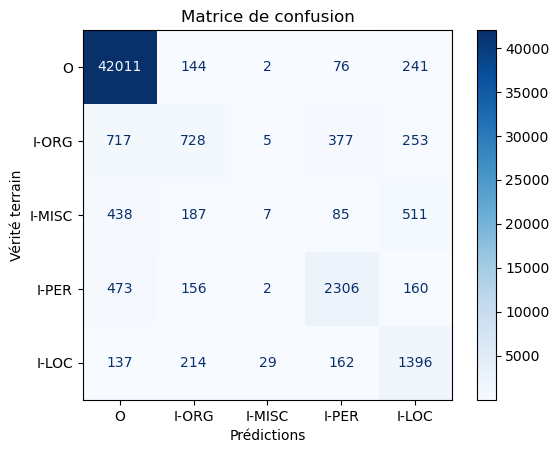

In [18]:
# Affichage de la matrice de confusion de manière plus lisible
disp = ConfusionMatrixDisplay(confusion_nltk, display_labels=unique_tags)
disp.plot(cmap='Blues')
plt.xlabel('Prédictions')
plt.ylabel('Vérité terrain')
plt.title('Matrice de confusion')
plt.show()

## 4. Performances de spaCy pour la NER

**4a.** Le NER de spaCy a aussi un jeu de tags différents de celui des données de test.  Veuillez chercher les informations pour compléter la fonction suivante qui convertir chaque tag du NER de spaCy dans le tag correspondant pour les données de test.  Attention à la logique des conversions. 

In [19]:
def convert_spacy_conll(spacy_tag):
    corresp = {'O': 'O',
               'ORG': 'I-ORG',
               'PERSON': 'I-PER',
               'LOC': 'I-LOC',
               'FAC': 'I-LOC',  # Facility
               'GPE': 'I-LOC',  # Geo-Political Entity
               'NORP': 'I-MISC',  # Nationalities or religious or political groups
               'LAW': 'I-MISC',
               'PRODUCT': 'I-MISC',
               'EVENT': 'I-MISC',
               'WORK_OF_ART': 'I-MISC',
               'MONEY': 'O',
               'LANGUAGE': 'O',
               'DATE': 'O',
               'TIME': 'O',
               'QUANTITY': 'O',
               'PERCENT': 'O',
               'CARDINAL': 'O',
               'ORDINAL': 'O',
               }
    if spacy_tag in corresp:
        return corresp[spacy_tag]
    else:
        print(f"Tag inconnu : {spacy_tag}")
        return 'I-MISC'


> Note: spaCy semble définir des entités beaucoup plus spécifiques que le format CoNLL-03 et NLTK, telles que les différents types de quantités (quantity, percent, cardinal, ordinal) et de temps (date, time). En comparant les scores obtenus après conversion, il a été décidé de retirer les entités de quantité et de temps, en les traduisant comme "outside" (O). Notre choix a également été appuyé par le fait que les deux résultats précédents ne prenant pas en compte ces éléments comme des entités nommées.

**4b.** Veuillez exécuter la NER de spaCy sur chacune des phrases de `test_tokens`, ce qui assure que spaCy aura la même tokenisation que les données de référence.  Veuillez stocker les tags dans une liste unique appelée `spacy_tags`.

In [20]:
spacy_tags = []

for sentence in test_tokens:
    doc = nlp(Doc(nlp.vocab, sentence))
    for token in doc:
        if token.ent_iob_ == 'O':
            spacy_tags.append('O')
        else:
            spacy_tags.append(token.ent_type_)

**4c.** Veuillez convertir les tags de `spacy_tags` grâce à la fonction précédente, dans une liste appelée `spacy_tags_conv`.  Veuillez afficher le nombre total de tags et les dix premiers.  Vous pouvez plusieurs essais en changeant la fonction, pour aboutir à la conversion qui maximise le score.

In [21]:
spacy_tags_conv = [convert_spacy_conll(tag) for tag in spacy_tags]

print(f"Nombre total de tags : {len(spacy_tags_conv)}")
print(f"Dix premiers tags : {spacy_tags_conv[:10]}")

Nombre total de tags : 50817
Dix premiers tags : ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


**4d.** Veuillez afficher le rapport d'évaluation de classification obtenu de Scikit-learn et la matrice de confusion pour tous les types de tags apparaissant dans les données de test.

In [22]:
report_spacy_sm = classification_report(test_tags, spacy_tags_conv, zero_division=0, digits=4)
print(f"Rapport d'évaluation :\n{report_spacy_sm}")

Rapport d'évaluation :
              precision    recall  f1-score   support

       I-LOC     0.7925    0.8019    0.7971      1938
      I-MISC     0.6996    0.6107    0.6522      1228
       I-ORG     0.5233    0.5240    0.5237      2080
       I-PER     0.8268    0.7123    0.7653      3097
           O     0.9659    0.9786    0.9722     42474

    accuracy                         0.9282     50817
   macro avg     0.7616    0.7255    0.7421     50817
weighted avg     0.9263    0.9282    0.9268     50817



In [23]:
confusion_spacy_sm = confusion_matrix(test_tags, spacy_tags_conv, labels=unique_tags)
print(f"Matrice de confusion : \n{confusion_spacy_sm}")

Matrice de confusion : 
[[41566   435   229   160    84]
 [  527  1090    41   224   198]
 [  251   147   750    34    46]
 [  511   275    26  2206    79]
 [  178   136    26    44  1554]]


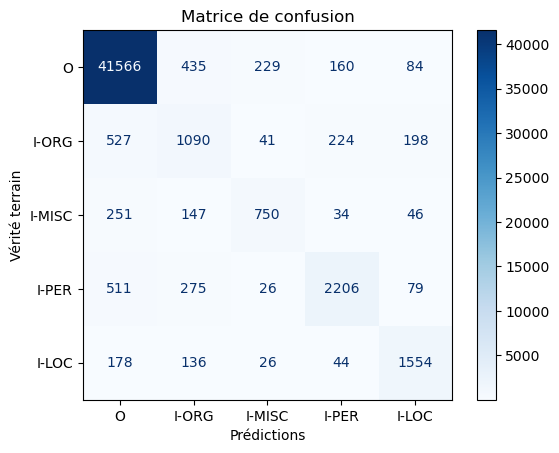

In [24]:
# Affichage de la matrice de confusion de manière plus lisible
disp = ConfusionMatrixDisplay(confusion_spacy_sm, display_labels=unique_tags)
disp.plot(cmap='Blues')
plt.xlabel('Prédictions')
plt.ylabel('Vérité terrain')
plt.title('Matrice de confusion')
plt.show()

**4e.** Veuillez exécuter également le modèle 'en_core_web_lg' de spacy et afficher le rapport d'évaluation (il n'est pas demander d'afficher la matrice de confusion).  Vous pouvez recopier ici le minimum de code nécessaire à l'obtention des résultats, avec une nouvelle pipeline spaCy appelée 'nlp2'.

In [25]:
# !python -m spacy download en_core_web_lg

nlp2 = spacy.load("en_core_web_lg")
spacy_tags2 = []
for sentence in test_tokens:
    doc = nlp2(Doc(nlp2.vocab, sentence))
    for token in doc:
        if token.ent_iob_ == 'O':
            spacy_tags2.append('O')
        else:
            spacy_tags2.append(token.ent_type_)

spacy_tags_conv2 = [convert_spacy_conll(tag) for tag in spacy_tags2]

report_spacy_lg = classification_report(test_tags, spacy_tags_conv2, zero_division=0, digits=4)
print(f"Rapport d'évaluation :\n{report_spacy_lg}")

Rapport d'évaluation :
              precision    recall  f1-score   support

       I-LOC     0.7541    0.8736    0.8095      1938
      I-MISC     0.8364    0.6580    0.7366      1228
       I-ORG     0.5519    0.6005    0.5752      2080
       I-PER     0.9134    0.8176    0.8628      3097
           O     0.9780    0.9803    0.9792     42474

    accuracy                         0.9430     50817
   macro avg     0.8068    0.7860    0.7926     50817
weighted avg     0.9447    0.9430    0.9432     50817



## 5. Utilisation d'embeddings contextualisés fournis par BERT

Dans cette section, vous allez évaluer un modèle basé sur le Transformer, qui fournit des embeddings contextualisés pour chaque token.  Ces embeddings sont ensuite utilisés par une couche finale (appelée _NER head_) pour assigner à chaque token une étiquette indiquant les entités nommées.  Le modèle et les instructions pour l'utiliser sont disponibles ici : https://huggingface.co/dslim/distilbert-NER (il s'agit d'une version de BERT "distillée" dans un modèle plus léger, suivi du _NER head_).

**5a.** Prise en main du modèle : à l'aide des exemples fournis sur Hugging Face, veuillez appliquer DistilBERT_NER sur les 3 premières phrases des données contenues dans `test_tokens` (voir le point 2c) et afficher les résultats obtenus.  Quelles sont les différences avec les résultats de NLTK et de spaCy ?

In [26]:
from transformers import pipeline, AutoTokenizer, AutoModelForTokenClassification

tokenizer = AutoTokenizer.from_pretrained("dslim/distilbert-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/distilbert-NER")

nlp_bert = pipeline("ner", model=model, tokenizer=tokenizer)

Device set to use cpu


In [27]:
for i in range(3):
    res = nlp_bert(' '.join(test_tokens[i]))    
    print(f"Phrase {i + 1}: {' '.join(test_tokens[i])}")
    print(f"Résultat: {res}\n")

Phrase 1: CRICKET - LEICESTERSHIRE TAKE OVER AT TOP AFTER INNINGS VICTORY .
Résultat: [{'entity': 'B-PER', 'score': np.float32(0.70779204), 'index': 6, 'word': 'L', 'start': 10, 'end': 11}, {'entity': 'B-PER', 'score': np.float32(0.6600711), 'index': 7, 'word': '##EI', 'start': 11, 'end': 13}, {'entity': 'B-PER', 'score': np.float32(0.6309051), 'index': 8, 'word': '##CE', 'start': 13, 'end': 15}, {'entity': 'B-PER', 'score': np.float32(0.7143562), 'index': 9, 'word': '##ST', 'start': 15, 'end': 17}, {'entity': 'B-PER', 'score': np.float32(0.7178321), 'index': 10, 'word': '##ER', 'start': 17, 'end': 19}, {'entity': 'B-PER', 'score': np.float32(0.8095978), 'index': 11, 'word': '##S', 'start': 19, 'end': 20}, {'entity': 'B-PER', 'score': np.float32(0.45343274), 'index': 12, 'word': '##H', 'start': 20, 'end': 21}, {'entity': 'B-PER', 'score': np.float32(0.72694325), 'index': 13, 'word': '##IR', 'start': 21, 'end': 23}, {'entity': 'B-PER', 'score': np.float32(0.76244366), 'index': 14, 'word

> Le modèle DistilBERT_NER fournit des résultats sous la forme d'une liste, contenant uniquement les entités nommées (les tokens "O" sont omis), accompagnées entre autres par le score de certitude du réseau de neurones.
>
> On constate que le mot "LEICESTERSHIRE", tout en majuscules, est inconnu du modèle et a donc été séparé en un ensemble de sous-tokens, préfixés par "##". Le modèle a catégorisé ces sous-tokens comme "PER" ce qui est incorrect dans ce contexte, puisqu'il s'agit d'un lieu. Le nommage du même mot dans la deuxième phrase est correct, lui attribuant le type "ORG", puisqu'il s'agit ici de l'équipe de sport représentant ce comté anglais.
>
> On notera également que "West Indian" a correctement été tag comme "MISC", puisqu'il s'agit de l'origine du joueur de cricket Phil Simmons. Dans ce cas, le modèle utilisé par spaCy pourrait reconnaitre cette entité nommée comme "NORP" (Nationalities or religious or political groups).
>
> En dehors du mot en majuscule, considéré comme inconnu, les scores de certitudes du modèle sont tous très bons et les entités nommées correspondantes ont correctement été classifiées. Le modèle a également bien identifié les noms de ville/région comme correspondant à leurs équipes de sport, comme en témoignent les tags "ORG" associés. La séparation entre les entités a également été faite de manière correcte (Phil Simmons a bien été reconnu comme une seule entité et les noms des villes se suivants dans les résultats sont bien considérés comme des entités distinctes).

**5b.** Le modèle DistilBERT utilise son propre tokeniseur, c'est pourquoi les étiquettes indiquant les entités nommées sont parfois portées par plusieurs *subwords* composant un mot.  Il faut donc parfois agréger une liste d'étiquettes en une seule.  

Veuillez écrire une fonction qui prend en entrée une liste d'étiquettes et retourne une seule étiquette : soit la première, soit celle qui est majoritaire.  Cette fonction sera utilisée plus loin.

In [28]:
def tag_fusion(tag_list, method='first'):
    """
    Fusionne une liste de tags en un seul tag selon la méthode spécifiée.

    Paramètres :
        tag_list (list) : Liste des tags à fusionner.
        method (str) : Méthode de fusion
             - 'first' : retourne le premier tag de la liste. Valeur par défaut
             - 'majority' : retourne le tag le plus fréquent dans la liste.

    Retour :
        str: Le tag fusionné selon la méthode choisie.

    Exceptions :
        ValueError : Si la méthode spécifiée n'est pas reconnue.
    """
    if method == 'first':
        return tag_list[0]
    elif method == 'majority':
        return Counter(tag_list).most_common(1)[0][0]
    else:
        raise ValueError()

print(tag_fusion(['O', 'B-PER', 'B-PER'], method='majority'))

B-PER


**5c.** Veuillez afficher le `set` des tags apparaissant dans les résultats de DistilBERT_NER sur les 50 premières phrases du corpus.  Comment se comparent-ils aux tags des données de test CoNLL ?

In [29]:
bert_tags = []
for i in range(50):
    res = nlp_bert(' '.join(test_tokens[i]))
    bert_tags += [tag['entity'] for tag in res]

unique_bert_tags = set(bert_tags)
print(f"Nombre de tags différents : {len(unique_bert_tags)}")
print(f"Tags différents : {unique_bert_tags}")

Nombre de tags différents : 8
Tags différents : {'B-MISC', 'B-LOC', 'I-MISC', 'I-ORG', 'B-ORG', 'I-PER', 'I-LOC', 'B-PER'}


> Les tags utilisent le format IOB (B- pour le début d'une entité, I- pour l'intérieur d'une entité), sans afficher les tokens qui ne font pas partie d'une entité nommée.
>
> Le modèle DistilBERT_NER utilise, tout comme CoNLL-2003, les quatre types (TYPE) d'entités nommées suivants : PER (personne), LOC (lieu), ORG (organisation) ou MISC (entités qui n'appartiennent pas aux trois groupes précédents). Les deux modèles utilisent donc la même nomenclature pour les entités nommées.

**5d.**  Sur le modèle des points 3a et 4a, veuillez écrire une fonction qui convertit les tags générés par DistilBERT_NER aux tags des donnéees de test.  Vous utiliserez cette fonction plus loin.  

In [30]:
def convert_bert_conll(bert_tag):
    if bert_tag.startswith('B-'):
        return 'I-' + bert_tag[2:]

    return bert_tag

**5e.** La pipeline DistilBERT_NER utilise son propre tokeniseur, qui ne peut pas être changé, car le modèle DistilBERT a été défini et entraîné avec lui.  On doit donc convertir les tokens du modèle à la même tokenisation que celle des données de test, en vue de l'évaluation.  Pour cela, on vous donne la fonction `convert_tokens` ainsi que du code pour la tester.  Veuillez étudier le code pour pouvoir l'utiliser plus bas, puis répondez aux questions ci-après.

In [31]:
def convert_tokens(ref_tokens, bert_result, word_ids):
    tokenized = tokenizer.tokenize(' '.join(ref_tokens))
    all_tags = []
    for tok, i in zip(tokenized, range(len(tokenized))):
        label = [tag['entity'] for tag in bert_result if tag['index'] == i+1]
        if label:
            label = label[0]
        else:
            label = 'O'
        if tok[:2] == '##' or word_ids[i] == word_ids[i-1]: 
            all_tags[-1].append(label)
        else:
            all_tags.append([label])
    return [tag_fusion(taglist, method='first') for taglist in all_tags]

In [32]:
# Test de la fonction convert_tokens:
i = 1  # choix de la phrase

def print_len(l):
    print(len(l), '--', l)

print_len(test_tokens[i])  # Affichage 1
tokenized_by_bert = tokenizer(test_tokens[i], add_special_tokens=False, is_split_into_words=True)
print_len(tokenizer.convert_ids_to_tokens(tokenized_by_bert["input_ids"]))  # Affichage 2
print_len(tokenized_by_bert.word_ids())  # Affichage 3
tagged_by_bert = nlp_bert(' '.join(test_tokens[i]))
print_len(tagged_by_bert)  # Affichage 4
print_len(convert_tokens(test_tokens[i], tagged_by_bert, tokenized_by_bert.word_ids()))  # Affichage 5

35 -- ['West', 'Indian', 'all-rounder', 'Phil', 'Simmons', 'took', 'four', 'for', '38', 'on', 'Friday', 'as', 'Leicestershire', 'beat', 'Somerset', 'by', 'an', 'innings', 'and', '39', 'runs', 'in', 'two', 'days', 'to', 'take', 'over', 'at', 'the', 'head', 'of', 'the', 'county', 'championship', '.']
38 -- ['West', 'Indian', 'all', '-', 'round', '##er', 'Phil', 'Simmons', 'took', 'four', 'for', '38', 'on', 'Friday', 'as', 'Leicestershire', 'beat', 'Somerset', 'by', 'an', 'innings', 'and', '39', 'runs', 'in', 'two', 'days', 'to', 'take', 'over', 'at', 'the', 'head', 'of', 'the', 'county', 'championship', '.']
38 -- [0, 1, 2, 2, 2, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
6 -- [{'entity': 'B-MISC', 'score': np.float32(0.99248767), 'index': 1, 'word': 'West', 'start': 0, 'end': 4}, {'entity': 'I-MISC', 'score': np.float32(0.9836288), 'index': 2, 'word': 'Indian', 'start': 5, 'end': 11}, {'entity': 'B-PER', 's

#### Questions

1. Que représentent les trois paramètres de convert_tokens ? Définissez-les comme dans une docstring.
   > - `ref_tokens`: liste des tokens de référence (i.e. la phrase complète du corpus CoNLL séparée en mots dans une liste)
   > - `bert_result`: liste des résultats de la pipeline DistilBERT_NER au format mentionné précédemment (Point 5a.)
   > - `word_ids`: liste des indices des tokens de référence dans le tokeniseur DistilBERT
2. Que représentent les cinq lignes affichées par le code de test ?
   > - Affichage 1: la phrase originale (tokens de référence)
   > - Affichage 2: les tokens de la phrase originale après tokenisation par le modèle DistilBERT, avec les différents sous-tokens. On constate une différence de longueur puisque le mot "all-rounder" a été séparé en quatre sous-tokens.
   > - Affichage 3: les indices des tokens de référence dans le tokeniseur DistilBERT. On constate ici que le mot "all-rounder" est maintenu à l'indice 2 pour ses 4 sous-tokens "all", "-", "round" et "##er".
   > - Affichage 4: les résultats de la pipeline DistilBERT_NER sur la phrase originale (tokenisée par le même tokenizer)
   > - Affichage 5: les résultats de la fonction convert_tokens sur la phrase originale (tokenisée par le même tokenizer). On y retrouve les tags de référence après conversion (i.e. le résultat final de la pipeline DistilBERT_NER), avec les tags "O" pour les tokens qui ne sont pas des entités nommées. Les tokens décomposés par le tokenizer de BERT ont aussi été fusionnés, ce qui permet de retrouver la longueur de la phrase originale.
3. Quels sont les deux problèmes traités par la fonction convert_tokens ?
   > - La gestion des tokens qui sont décomposés en plusieurs sous-tokens connus par le vocabulaire du modèle et leur reconstruction en un seul token
   > - L'inclusion des tags "O" pour les tokens qui ne sont pas donnés comme des entités nommées par la pipeline


**5f.** Veuillez effectuer la reconnaissance des entités nommées avec la pipeline DistilBERT_NER et obtenir la liste finale de tags avec les noms convertis à ceux du jeu de référence grâce à `convert_bert_conll`.

In [33]:
j = len(test_tokens)  # se limiter aux j premières phrases sur les 2970 (utile pendant le développement, mais les utiliser toutes à la fin)

bert_tags = []
for i in range(j):
    tokenized_by_bert = tokenizer(test_tokens[i], add_special_tokens=False, is_split_into_words=True)
    bert_result = nlp_bert(' '.join(test_tokens[i]))
    res = convert_tokens(test_tokens[i], bert_result, tokenized_by_bert.word_ids())
    bert_tags += res

bert_tags_conv = [convert_bert_conll(tag) for tag in bert_tags]

print(len(bert_tags_conv))

50817


**5g.** En comparant `test_tags` avec `bert_tags_conv`, veuillez afficher le rapport d'évaluation de la classification et la matrice de confusion, pour tous les types de tags apparaissant dans les données de test.

In [34]:
report_bert = classification_report(test_tags, bert_tags_conv, zero_division=0, digits=4)
print(f"Rapport d'évaluation :\n{report_bert}")

Rapport d'évaluation :
              precision    recall  f1-score   support

       I-LOC     0.9551    0.9556    0.9554      1938
      I-MISC     0.9072    0.8917    0.8994      1228
       I-ORG     0.9319    0.9279    0.9299      2080
       I-PER     0.9787    0.9803    0.9795      3097
           O     0.9968    0.9973    0.9971     42474

    accuracy                         0.9893     50817
   macro avg     0.9540    0.9506    0.9522     50817
weighted avg     0.9893    0.9893    0.9893     50817



In [35]:
confusion_bert = confusion_matrix(test_tags, bert_tags_conv, labels=unique_tags)
print(f"Matrice de confusion : \n{confusion_bert}")

Matrice de confusion : 
[[42361    40    47     8    18]
 [   40  1930    41    34    35]
 [   56    42  1095    13    22]
 [   23    19     7  3036    12]
 [   18    40    17    11  1852]]


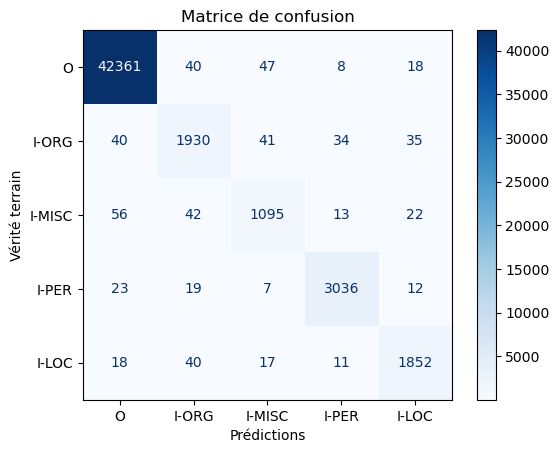

In [36]:
# Affichage de la matrice de confusion de manière plus lisible
disp = ConfusionMatrixDisplay(confusion_bert, display_labels=unique_tags)
disp.plot(cmap='Blues')
plt.xlabel('Prédictions')
plt.ylabel('Vérité terrain')
plt.title('Matrice de confusion')
plt.show()

**5h.** Laquelle des deux stratégies de `tag_fusion` (premier tag ou tag majoritaire) conduit à de meilleurs résultats ?  Veuillez effectuer l'expérience et indiquer simplement les scores obtenus et votre conclusion dans le champ suivant.  Pour la conclusion finale, gardez 'first'.

> #### Avec le premier tag
> ```
> Rapport d'évaluation :
>               precision    recall  f1-score   support
> 
>        I-LOC     0.9551    0.9556    0.9554      1938
>       I-MISC     0.9072    0.8917    0.8994      1228
>        I-ORG     0.9319    0.9279    0.9299      2080
>        I-PER     0.9787    0.9803    0.9795      3097
>            O     0.9968    0.9973    0.9971     42474
>
>     accuracy                         0.9893     50817
>    macro avg     0.9540    0.9506    0.9522     50817
> weighted avg     0.9893    0.9893    0.9893     50817
> ```
>
> #### Avec le tag majoritaire
> ```
> Rapport d'évaluation :
>               precision    recall  f1-score   support
> 
>        I-LOC     0.9571    0.9561    0.9566      1938
>       I-MISC     0.9073    0.8925    0.8998      1228
>        I-ORG     0.9319    0.9274    0.9296      2080
>        I-PER     0.9784    0.9797    0.9790      3097
>            O     0.9968    0.9974    0.9971     42474
> 
>     accuracy                         0.9894     50817
>    macro avg     0.9543    0.9506    0.9524     50817
> weighted avg     0.9893    0.9894    0.9893     50817
> ```
> 
> #### Conclusion
> Dans l'ensemble, les résultats sont pratiquement identiques et sont visibles uniquement si le nombre de décimales est suffisant. Ces différences se constatent également au niveau de la moyenne macro, qui mesure la différence entre les deux méthodes dans l'ordre du millième. La méthode de la majorité est légèrement meilleure, bien que la différence soit négligeable. Étant donné que cette méthode requiert l'utilisation d'un compteur pour déterminer la majorité, il est plus efficace d'utiliser la première méthode, plus rapide et ne nécessitant pas de calcul supplémentaire.

## 6. Discussion finale

Veuillez comparer les scores des quatre modèles testés, en termes de **macro avg**.  Pourquoi ce score est-il le plus informatif ?  Veuillez indiquer également la taille des modèles spaCy évalués.

In [37]:
reports = {
    "NLTK": report_nltk,
    "spaCy sm" : report_spacy_sm,
    "spaCy lg" : report_spacy_lg,
    "DistilBERT": report_bert,
}

df = pd.DataFrame(
    {name: list(map(float, re.search(r"macro avg\s+([\d\.]+)\s+([\d\.]+)\s+([\d\.]+)", report).groups()))
     for name, report in reports.items()}
).T

df.columns = ["Macro avg Precision", "Macro avg Recall", "Macro avg F1-Score"]
display(df)

,Macro avg Precision,Macro avg Recall,Macro avg F1-Score
NLTK,0.5874,0.5619,0.5553
spaCy sm,0.7616,0.7255,0.7421
spaCy lg,0.8068,0.7860,0.7926
DistilBERT,0.9540,0.9506,0.9522


> |               | spaCy sm | spaCy LG |
> |---------------|----------|----------|
> | **taille**    | 12 Mo    | 382 Mo   |
>
> La macro-moyenne est une moyenne qui n'est pas pondérée par le nombre d'éléments de chaque classe. Elle accorde donc le même poids à chaque classe, indépendamment de la distribution des éléments entre les différentes classes, permettant à chaque classe de contribuer de manière égale au score. Ce type de moyenne est très utile dans les jeux de données déséquilibrés, comme c'est le cas dans ce laboratoire (42474/50817 tokens, soit 83.6%, ne sont pas des entités nommées et appartiennent à la classe 'O'). La macro-moyenne est donc plus informative, car elle permet de voir la performance du modèle indépendamment de la taille des classes et donc sans ce biais, propre aux classes déséquilibrées.
>
> En observant les valeurs obtenues, il est rapidement visible que le modèle DistilBERT est bien meilleur que les autres et que le modèle spaCy lg performe mieux que le modèle sm.
>
> NLTK est le modèle ayant les résultats les plus faibles, en grande partie parce qu’il utilise un modèle de machine learning traditionnel (maxent), moins performant que les architectures basées sur des réseaux de neurones. De plus, il n’a pas été préentrainé sur un corpus spécifique pour la reconnaissance d’entités nommées (NER). Son corpus d'entraînement est aussi plus petit, ce qui limite sa capacité à généraliser sur des données inconnues.
>
> spaCy performe mieux, avec une macro-moyenne du F1-score à 0.74 pour le modèle sm et 0.79 pour le modèle lg, bien que ces scores sont légèrement plus bas que ceux spécifiés dans la documentation (respectivement, 0.84 et 0.86). À nouveau, cette différence est sûrement due à la différence des corpus utilisés pour l'entraînement. On constate également que le modèle lg (382 Mo), environ 30 fois plus lourd que le modèle sm (12 Mo), n'apporte pas une grande différence de performance. Dans un cas de figure où les ressources utilisées seraient aussi importantes que les performances, le modèle sm sera considéré comme un meilleur choix.
>
> DistilBERT est le modèle le plus performant, avec un score de 0.95. Ce modèle est basé sur un transformer et a été préentrainé sur le même corpus que nous avons utilisé, dans sa version de test, pour évaluer les résultats des modèles (CoNLL-03). L'utilisation d'un réseau de neurones permet au modèle d'apprendre des relations entre les mots et de mieux généraliser sur des données inconnues. Cependant, une partie des performances constatée est sans doute due à l'utilisation d'un jeu de données d'entraînement contextuellement proche de celui utilisé pour l'évaluation et l'on peut donc émettre quelques réserves sur la performance de généralisation du modèle.

**Fin du Labo.** Veuillez nettoyer ce notebook en gardant seulement les résultats désirés, l'enregistrer, et le soumettre comme devoir sur Cyberlearn.